In [242]:
import pandas as pd
import numpy as np
from numpy import array
import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
today = date.today()
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pykalman import KalmanFilter

In [243]:
startDate = '2014-01-01'
endDate = today
 
# Fetching the data
StockData = yf.download(['AIZ', 'AWK'], start=startDate, end=endDate, progress=False)['Close']

<Axes: xlabel='Date'>

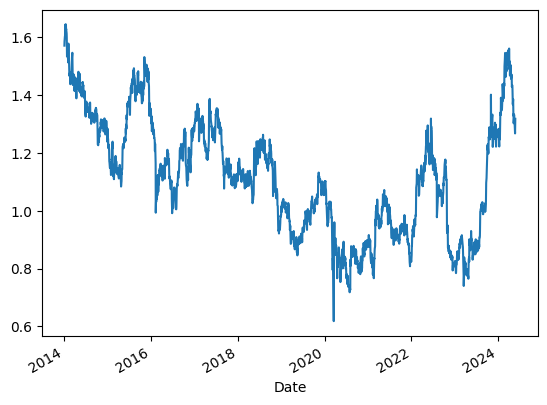

In [244]:
stock_ratio = (StockData['AIZ'] / StockData['AWK'])
stock_ratio.plot()

In [245]:
def fitKCA(t,z,q):
    '''
    Inputs:
    t: Iterable with time indices
    z: Iterable with measurements
    q: Scalar that multiplies the seed states covariance

    Output:
    x[0]: smoothed state means of position velocity and acceleration
    x[1]: smoothed state covar of position velocity and acceleration
    Dependencies: numpy, pykalman
    '''
    #1) Set up matrices A,H and a seed for Q
    h=(t[-1]-t[0]).days/t.shape[0]
    A=np.array([[1,h,.5*h**2],
    [0,1,h],
    [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2) Apply the filter
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)

    # Filtering
    state_means, state_covs = kf.filter(z)
    return state_means,state_covs

In [246]:
state_means,state_covs = fitKCA(stock_ratio.index, stock_ratio.values, 1)
kca = pd.DataFrame(state_means, index=stock_ratio.index, columns=['position', 'velocity', 'acceleration']).iloc[1:]

<Axes: xlabel='Date'>

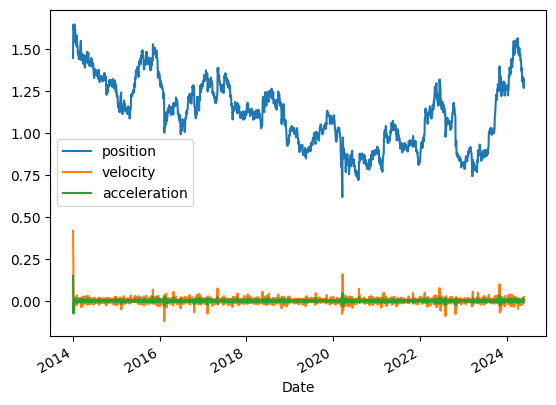

In [247]:
kca.plot()

In [248]:
dataset = pd.concat([kca, stock_ratio.to_frame('stock_ratio').shift(-1)], axis = 1).dropna()

In [249]:

dataset

,position,velocity,acceleration,stock_ratio
Date,,,,
2014-01-03,1.445057,0.416737,0.147292,1.602421
2014-01-06,1.642977,0.221131,0.009738,1.602014
2014-01-07,1.622822,-0.023772,-0.076132,1.620624
2014-01-08,1.614542,-0.055438,-0.050092,1.643750
2014-01-09,1.635020,-0.014229,-0.012479,1.613241
...,...,...,...,...
2024-05-17,1.311603,0.003016,0.002706,1.289137
2024-05-20,1.290732,-0.013891,-0.004176,1.275528
2024-05-21,1.275027,-0.013398,-0.002012,1.267364


<Axes: xlabel='Date'>

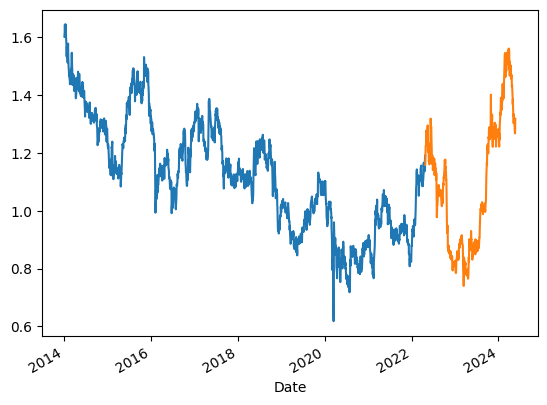

In [250]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset[['position', 'velocity', 'acceleration']], dataset[['stock_ratio']].shift(-1), test_size = 0.2, shuffle = False)
y_train['stock_ratio'].plot()
y_test['stock_ratio'].plot()

In [251]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
 
DataScaler_x = sc.fit(X_train)
X_train_std = DataScaler_x.transform(X_train)
X_test_std = DataScaler_x.transform(X_test)
X_latest_std = DataScaler_x.transform(kca)

DataScaler_y = sc.fit(y_train)
y_train_std = DataScaler_y.transform(y_train)
y_test_std = DataScaler_y.transform(y_test)

In [252]:
TimeSteps=30  # next day's Price Prediction is based on last TimeSteps past day's prices
Features = X_train.shape[1]

In [253]:
def window_time_series(series, n, step = 1, label = False):
#    print "in window_time_series",series
    if step < 1.0:
        step = max(int(step * n), 1)
    if label == False:
        return [series[i:i+n] for i in range(0, len(series) - n + 1, step)]
    else:
        return [series[i:i+n][-1] for i in range(0, len(series) - n + 1, step)]

In [254]:
X_train_std_window = np.array(window_time_series(X_train_std, TimeSteps, step = 1))
X_test_std_window = np.array(window_time_series(X_test_std, TimeSteps, step = 1))
X_latest_std_window = np.array(window_time_series(X_latest_std, TimeSteps, step = 1))


y_train_std_window = np.array(window_time_series(y_train_std, TimeSteps, step = 1, label = True))
y_test_std_window = np.array(window_time_series(y_test_std, TimeSteps, step = 1, label = True))

In [255]:
print(f"X shape = {X_train_std_window.shape}, y shape = {y_train_std_window.shape}")

X shape = (2063, 30, 3), y shape = (2063, 1)


In [256]:
# Initialising the LSTM
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, Features), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, Features), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
regressor.add(Dense(units = 1))
  
# Compiling the LSTM choose either sgd or Adam
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

/Users/wei/anaconda3/envs/AdvancedRiskManagement/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [257]:
regressor.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 10)         │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 30, 5)          │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 5)              │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,106 (4.32 KB)

 Trainable params: 1,106 (4.32 KB)

 Non-trainable params: 0 (0.00 B)

In [290]:
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
history = regressor.fit(X_train_std_window, y_train_std_window, validation_split=0.1, epochs=30, batch_size=80, verbose=1,shuffle=False)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0591 - val_loss: 0.0257
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0759 - val_loss: 0.0210
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0515 - val_loss: 0.0195
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0494 - val_loss: 0.0247
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0330 - val_loss: 0.0193
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0303 - val_loss: 0.0243
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0332 - val_loss: 0.0191
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0329 - val_loss: 0.0208
Epoch 9/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0363 - val_loss: 0.0193
Epoch 10/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0313 - val_loss: 0.0203
Epoch 11/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0322 - val_loss: 0.0189
Epoch 12/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

In [291]:
def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

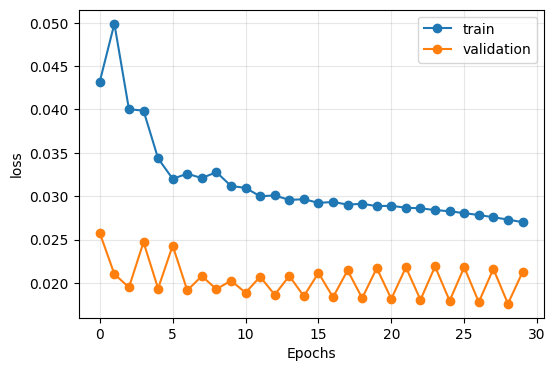

In [292]:
plt.figure(figsize=(6,4))
plot_train_history(history, 'loss','val_loss')
plt.grid(alpha = 0.3)

In [293]:
# Making predictions on test data
predicted_y = regressor.predict(X_test_std_window)
predicted_y = DataScaler_y.inverse_transform(predicted_y)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [294]:
predicted_y = pd.Series(predicted_y.reshape(-1), index = y_test.index[-len(predicted_y):])

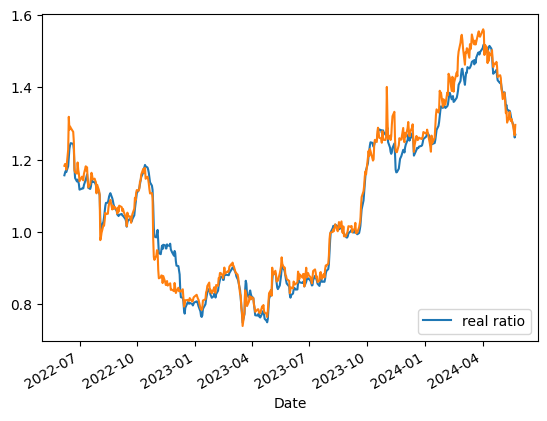

In [295]:
predicted_y.plot()
stock_ratio.loc[predicted_y.index].plot()
plt.legend(['real ratio'], loc = 4)


In [296]:
predicted_y

Date
2022-06-07    1.156872
2022-06-08    1.163784
2022-06-09    1.168581
2022-06-10    1.165647
2022-06-13    1.182168
                ...   
2024-05-17    1.310845
2024-05-20    1.295144
2024-05-21    1.282154
2024-05-22    1.261560
2024-05-23    1.269367
Length: 494, dtype: float32

In [297]:
signal = ((predicted_y.shift(-1) - stock_ratio.loc[predicted_y.index]) > 0) * 2 - 1

<Axes: xlabel='Date'>

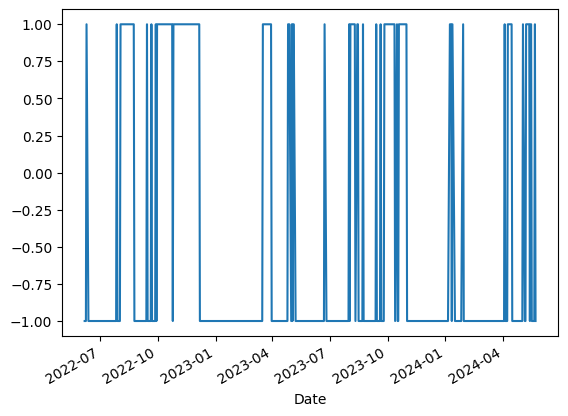

In [298]:
signal.plot()

In [299]:
rtns = StockData.diff(1) / StockData

In [300]:
rtn = rtns['AIZ'] - rtns['AWK']

<Axes: xlabel='Date'>

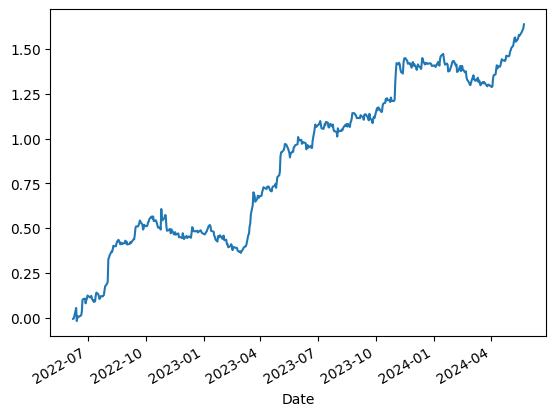

In [301]:
(signal.shift(1) * rtn).cumsum().plot()

In [302]:
new_y = regressor.predict(X_latest_std_window)
new_y = DataScaler_y.inverse_transform(new_y)

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [303]:
new_y = pd.DataFrame(new_y, index = kca.index[29:])
new_y.tail()

,0
Date,
2024-05-20,1.295144
2024-05-21,1.282154
2024-05-22,1.261560
2024-05-23,1.269367
2024-05-24,1.273597


In [304]:
stock_ratio

Date
2014-01-02    1.570947
2014-01-03    1.585142
2014-01-06    1.602421
2014-01-07    1.602014
2014-01-08    1.620624
                ...   
2024-05-20    1.289137
2024-05-21    1.275528
2024-05-22    1.267364
2024-05-23    1.296345
2024-05-24    1.317866
Length: 2617, dtype: float64

In [305]:
StockData

Ticker,AIZ,AWK
Date,,
2014-01-02,65.320000,41.580002
2014-01-03,65.720001,41.459999
2014-01-06,66.180000,41.299999
2014-01-07,66.820000,41.709999
2014-01-08,67.580002,41.700001
...,...,...
2024-05-20,172.190002,133.570007
2024-05-21,171.380005,134.360001
2024-05-22,169.509995,133.750000
